# Requierements

In [11]:

#!pip install scipy
#!pip install Rhodium


# First Steps

# Problem
The Lake Problem models a hypothetical town situated near a lake. The lake provides tourism and recreation activities for the town, and thus the town's inhabitants wish to maintain the quality of the lake. However, industrial activities and farming release pollutants into the lake. The goal of this exercise is to determine an acceptable level of pollution that can be released without polluting the lake. We will have to balance the desire for increased economic activity (which increases pollution) with the aversion to polluting the lake.

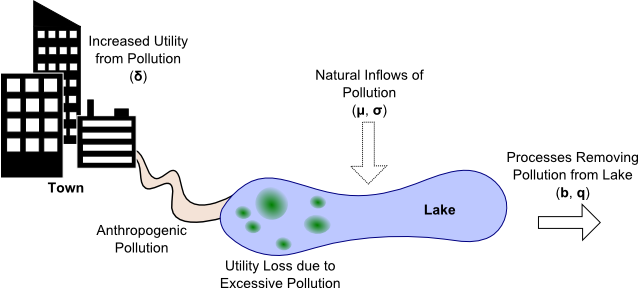


This system is driven by five parameters. 
* **mean**  and **stdev** control the amount of naturally-occurring pollution that enters the lake and can not be controlled. 
* **b** and **q** control how quickly the lake can remove pollution through various natural processes. 
* **delta** specifies the discount rate for valuing the economic benefit in future years.

## Creating a model
The model can be any Python function, with any number of input arguments. The names of the input arguments will become important later. The model can also return any number of outputs. 

Inputs:
* 5 system variables
* **pollution_limit** will reflect the level of allowed pollution. It will be a list with 100 values, specifying the allowed pollution for each year in the 100 year simulation. The remaining arguments will remain fixed for this exercise.

In [12]:
#Python model for the Lake Problem 
from scipy.optimize import brentq as root
import numpy as np
import math

def lake_problem(
        pollution_limit,
        b = 0.42,        # decay rate for P in lake (0.42 = irreversible)
        q = 2.0,         # recycling exponent
        mean = 0.02,     # mean of natural inflows
        stdev = 0.001,   # standard deviation of natural inflows
        alpha = 0.4,     # utility from pollution
        delta = 0.98,    # future utility discount rate
        nsamples = 100): # monte carlo sampling of natural inflows)
    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(pollution_limit)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(pollution_limit)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    intertia = np.sum(np.diff(decisions) > -0.02)/float(nvars-1)
    
    return (max_P, utility, intertia, reliability)

## Rhodium model. 
A Rhodium model provides additional annotations for the function above. In particular, we will identify all parameters (inputs) and responses (outputs) of interest.

In addition to providing a name for each response, you can also specify if the response is an objective to be minimized or maximized, or indicate the response is "informational" and should not be optimized.


In [13]:
from rhodium import *
model = Model(lake_problem)

model.parameters = [Parameter("pollution_limit"),
                    Parameter("b"),
                    Parameter("q"),
                    Parameter("mean"),
                    Parameter("stdev"),
                    Parameter("delta")]

model.responses = [Response("max_P", Response.MINIMIZE),
                   Response("utility", Response.MAXIMIZE),
                   Response("inertia", Response.MAXIMIZE),
                   Response("reliability", Response.MAXIMIZE)]

### Constraints.

Is a valid Python expression that can reference any parameter or response. You should in general try to keep each constraint simple, such as simple equality or inequality expressions, which will help improve the performance of the optimization algorithm.

In [14]:
model.constraints = [Constraint("reliability >= 0.95")]

## Optimizing the Model
Rhodium will attempt the optimize the responses you defined subject to any constraints by tweaking levers.

Levers are parameters that we can control when implementing a policy. For the lake problem, we are controlling the amount of pollution released yearly into the lake. Thus, we will define a lever for our pollution_limit parameter to be 100 values between 0.0 and 0.1.

In [15]:
model.levers = [RealLever("pollution_limit", 0.0, 0.1, length=100)]

Next, we call optimize to optimize the problem. The optimization algorithm will iteratively adjust the levers while searching for an optimal policy. If more than one response is defined, such as in this example, then typically many Pareto optimal responses can be found. None of the identified Pareto optimal policies is better than any other; instead they form a tradeoff among the responses, some with better performance with respect to one or more responses but worse in others.

In [16]:
output = optimize(model, "NSGAII", 10000)
print("Found", len(output), "optimal policies!")

Found 100 optimal policies!


Here, output is a Rhodium data set containing one or more optimal policies. 

In [20]:
output[0]

OrderedDict([('pollution_limit',
              [0.015403917253077368,
               0.04172418941128504,
               0.06472449022158691,
               0.07105871156862255,
               0.034068580310957684,
               0.03182599646850934,
               0.004505346124635866,
               0.009535810920424936,
               0.09890968435572,
               0.011013098527129292,
               0.004021729108358617,
               0.017379969558200405,
               0.07506402996463107,
               0.010938442717827653,
               0.04460142015211117,
               0.01634594823870149,
               0.045555211091251935,
               0.018045830464817638,
               0.009889939914308307,
               0.004842333015481392,
               0.011211663335651049,
               0.012708702441519582,
               0.046758690336224,
               0.022153370927608735,
               0.06359273625103215,
               0.030788885778064268,
               0.026

We can reference specific policies by index, such as output[5], or by searching for a policy with certain traits using the find, find_min, and find_max methods. We can also use the apply method to perform calculations on the data. 

In [21]:
policy = output[5]
policy = output.find_max("reliability")
policies = output.find("utility > 0.5")
result = output.apply("sum(pollution_limit)")

For some analyses, it can be useful to have this data in other formats, such as Pandas' DataFrame and Numpy's ndarray.

In [22]:
#df = output.as_dataframe()
#arr = output.as_array()

# visual Inspection

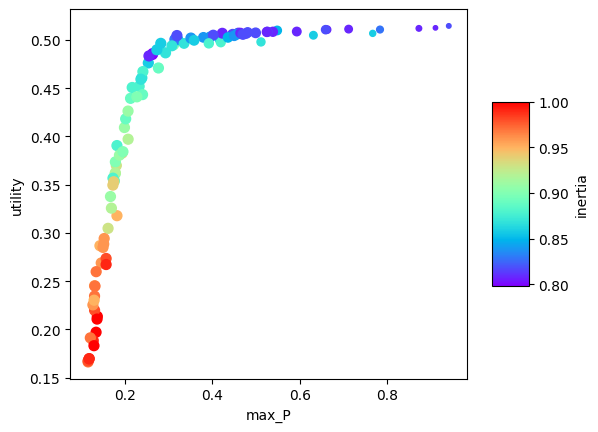

In [23]:
fig = scatter2d(model, output)

Rhodium by default assumes that it should plot the model responses. These responses are automatically plotted on the x, y, z (for 3D plots), color, and size axes. This can be customized. For example, we can color each point with their reliability:

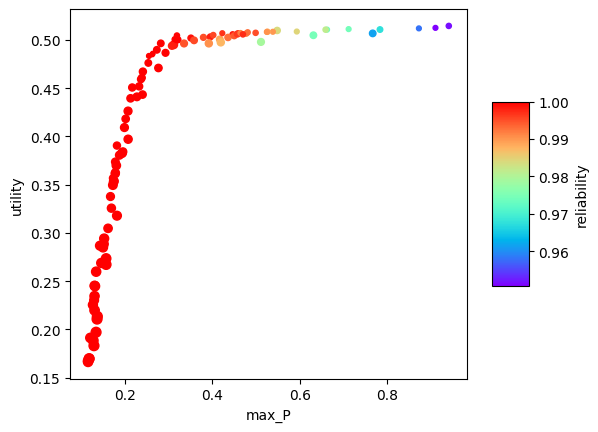

In [24]:
fig = scatter2d(model, output, c="reliability")

We can similary generate 3D plots 

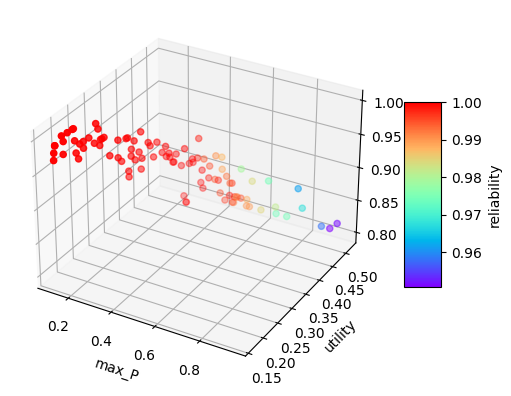

In [28]:
fig = scatter3d(model, output, c="reliability")

We can simplify the plotting of relationships/interactions by generating pairwise scatter plots

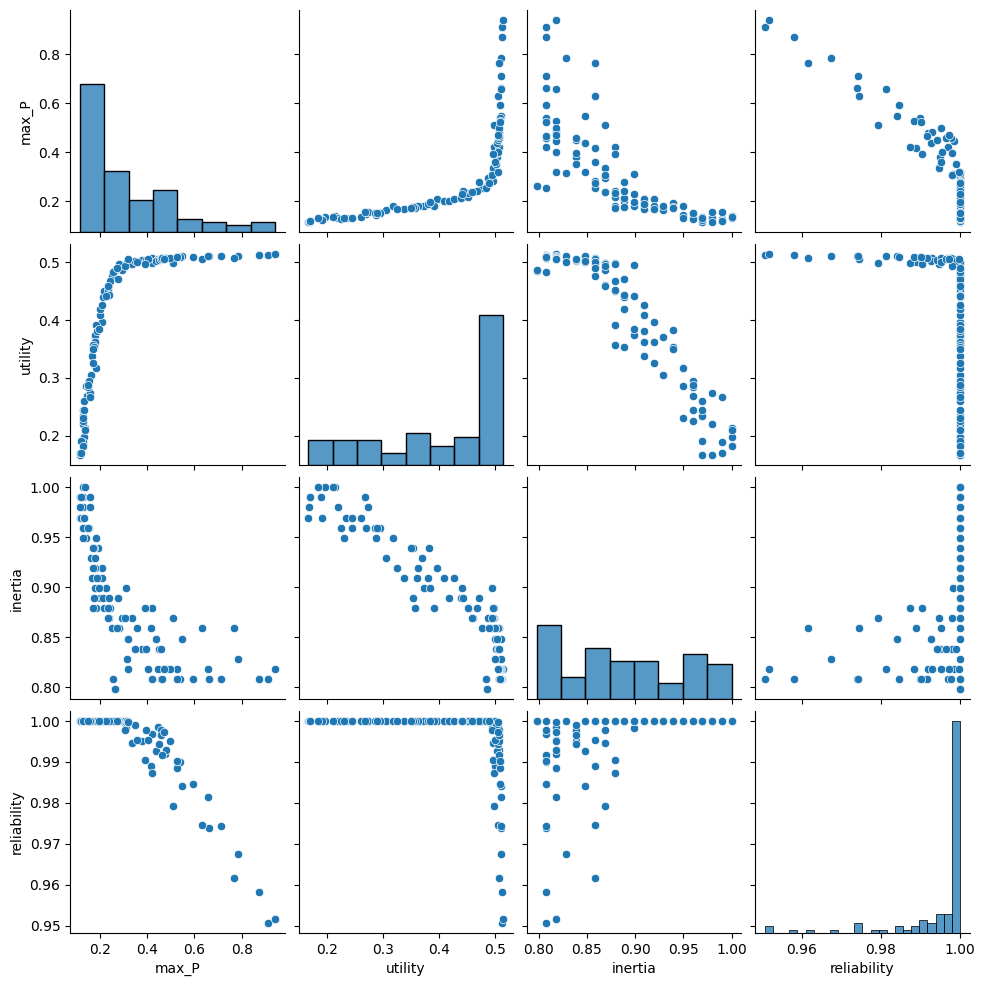

In [29]:
fig = pairs(model, output)

Another commonly used way to view interactions between factors is parallel coordinates plots

# Scenario Discovery
Using optimization, we leveraged an automated search procedure to identify optimal policies for our model. We can also manually explore different policies. Recall that a policy is simply a Python dictionary with keys mapping to our parameters. We can construct new policies by creating dictionaries with whatever parameters we wish to control. For example, here is a policy where we allow a yearly pollution level of 0.02

In [31]:
policy = {"pollution_limit" : [0.02]*100}

In [32]:
result = evaluate(model, policy)

In [36]:
print("Max Phosphorus in Lake:", result["max_P"]) 
print("Utility:               ", result["utility"])
print("Inertia:               ", result["inertia"]) 
print("Reliability:           ", result["reliability"]) 

Max Phosphorus in Lake: 0.14311626225247098
Utility:                0.3469521776420985
Inertia:                1.0
Reliability:            1.0000000000000007


When we evaluate the policies in this manner, we are assuming there is no uncertainty. The default values for each parameter is used in the calculation. We can also explore the effects of uncertainties on our policy. First, we must define the uncertain parameters and their distributions. Below we use uniformly-distributed uncertainties, but other distributions such as normal and log-normal are also supported.

In [37]:
model.uncertainties = [UniformUncertainty("b", 0.1, 0.45),
                       UniformUncertainty("q", 2.0, 4.5),
                       UniformUncertainty("mean", 0.01, 0.05),
                       UniformUncertainty("stdev", 0.001, 0.005),
                       UniformUncertainty("delta", 0.93, 0.99)]

Next, we will create many possible states-of-the-world (SOWs), each representing some combination of the uncertainty parameters. Here, we generate 1000 SOWs:

In [38]:
SOWs = sample_lhs(model, 1000)

Then, using the evaluate method, we evaluate our policy in each SOW.

In [39]:
results = evaluate(model, update(SOWs, policy))

In [40]:
classification = results.apply("'Reliable' if reliability > 0.9 else 'Unreliable'")

Now we will use the Patient Rule Induction Method (PRIM) to identify the key uncertainties that cause a SOW to fall within either class. This process is termed "scenario discovery". PRIM works by restricting the dimensions (bounds) for each uncertainty that contains the SOWs of interest. We refer to these restrictions as a "box".

PRIM is an iterative process. We call find_box() followed by box.show_tradeoff() to display visually the dimension restrictions in terms of two metrics: coverage and density. Coverage measures the percentage of cases of interest contained within the box and density considers the percentage of cases within the box that are of interest. Having a coverage and density of 100% is ideal. Note we provide the coi argument to indicate we are interested in solutions classified as "Reliable"

c:\Users\L03558343\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\Repos\DMDU\.conda\lib\site-packages\prim\prim_alg.py:213: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ((unique_y.shape[0] == 2 and (False not in unique_y or True not in unique_y)) or


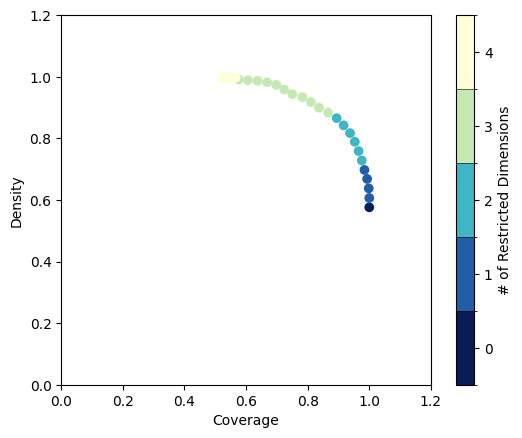

In [41]:
p = Prim(results, classification, include=model.uncertainties.keys(), coi="Reliable")
box = p.find_box()
fig = box.show_tradeoff()

Each point in the above plot represents a sequence of restrictions on the dimensions (a peeling trajectory). Typically, as we restrict each dimension further, we improve density but reduce coverage.

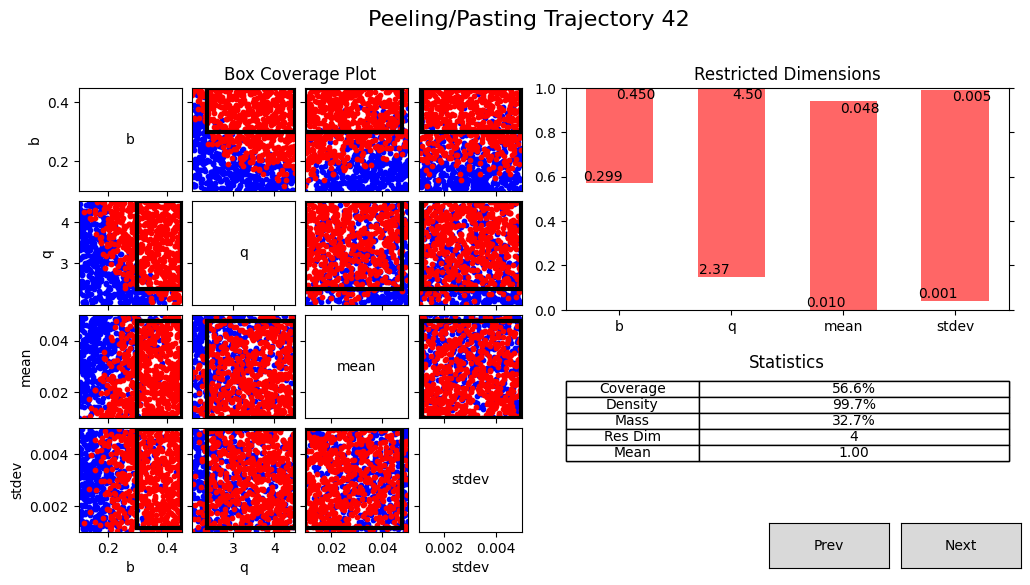

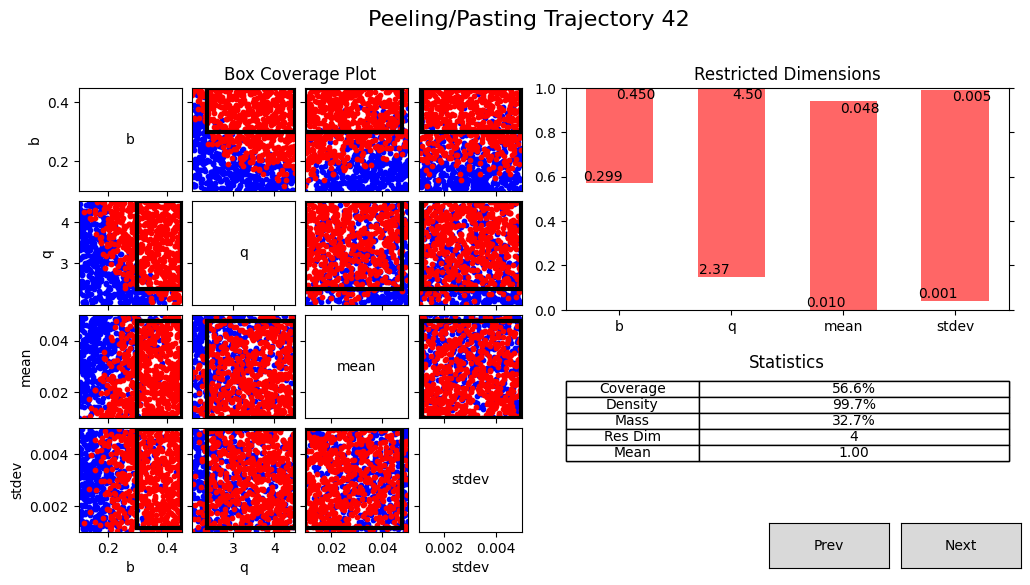

In [42]:
box.show_details()

# Sensitivity Analysis

Rhodium also automates the task of performing global and regional sensitivity analysis on the model uncertainties. 

Morris method to identify the sensitive parameters with respect to reliability

In [45]:
result = sa(model, "reliability", policy=policy, method="morris", nsamples=1000, num_levels=4, grid_jump=2)
print(result)

Morris Method's mu:
        b: +0.761171
        q: +0.492736
     mean: -0.236044
    stdev: -0.001129
    delta: -0.000147
Morris Method's mu* (confidence interval):
        b: +0.761171 (+0.086231)
        q: +0.492736 (+0.087200)
     mean: +0.236044 (+0.057074)
    stdev: +0.002124 (+0.001192)
    delta: +0.000975 (+0.000729)
Morris Method's sigma:
        b: +0.579973
        q: +0.544611
     mean: +0.375914
    stdev: +0.008156
    delta: +0.004666


Concurring with the PRIM analysis, parameters b, q, and mean exhibit the largest sensitivites. Some methods, like the Morris method, only analyze the effects of parameters in isolation. The Sobol method lets us also compute second-order and total-order indices capturing the interactions between parameters

In [46]:
result = sa(model, "reliability", policy=policy, method="sobol", nsamples=10000)
print(result)

c:\Users\L03558343\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\Repos\DMDU\.conda\lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (834) is equal to `2^n`.
        
  warnings.warn(msg)


First order sensitivity indices (confidence interval):
        b: +0.529999 (+0.083468)
        q: +0.227313 (+0.064600)
     mean: +0.078872 (+0.046455)
    stdev: -0.000345 (+0.000557)
    delta: -0.000157 (+0.000307)
Total order sensitivity indices (confidence interval):
        b: +0.726795 (+0.071923)
        q: +0.415588 (+0.054117)
     mean: +0.202326 (+0.038706)
    stdev: +0.000032 (+0.000023)
    delta: +0.000010 (+0.000007)
Second order sensitivity indices (confidence interval):
            b - q: +0.050669 (+0.087125)
         b - mean: +0.003215 (+0.081098)
        b - stdev: -0.001040 (+0.074934)
        b - delta: -0.000808 (+0.075108)
         q - mean: +0.010315 (+0.090465)
        q - stdev: +0.038866 (+0.071822)
        q - delta: +0.038392 (+0.071841)
     mean - stdev: +0.001088 (+0.053073)
     mean - delta: +0.001078 (+0.053127)
    stdev - delta: +0.000145 (+0.000767)


We can also visualize the results from sensitivity analysis. For example, below we plot the first and total-order sensitivity indices for the Sobol method. Similar 2D bar plots can be shown for all other supported methods.

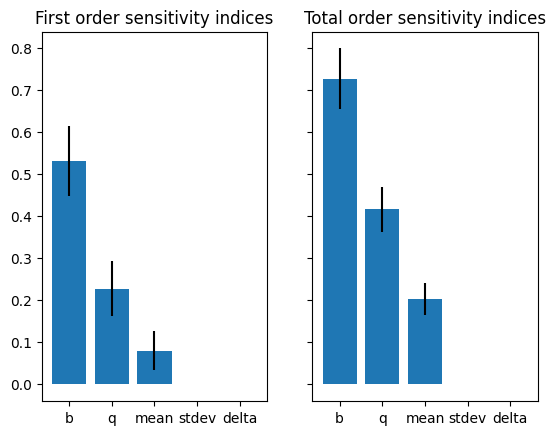

In [47]:
fig = result.plot()

If using Sobol's method, we can also generate a "spider" or "radial" plot showing the second-order indices. In the figure below, the first and total-order indices for each parameter are indicated by the solid circle and the outer ring, respectively, where a larger radius indicates larger effects. The gray lines connecting the circles represents the second-order indices, with thicker lines corresponding to larger second-order effects.